In [5]:
import numpy as np
import matplotlib.pyplot as plt
import camb

In [6]:
from tqdm import tqdm

# Main code

### Arrays y grids de los omega

In [19]:
omega_m = np.linspace(-1, 3, 400)
omega_lambda = np.linspace(-1, 3, 400)


omega_lambda_grid, omega_m_grid = np.meshgrid(omega_lambda, omega_m)
omega_k_grid = 1 - (omega_m_grid + omega_lambda_grid)


### Parámetros

In [20]:
import astropy.units as u
from astropy.constants import c

H_0 = 67.4
c = c.to(u.km / u.s).value
z = np.linspace(0, 1000, 5)

### Definir integral sobre el redshift

In [21]:
def E(z, omega_m, omega_k, omega_lambda):
    return np.sqrt(
        omega_m * (1 + z)**3 +
        omega_k * (1 + z)**2 +
        omega_lambda
    )

from scipy.integrate import quad
E_grid = np.empty_like(omega_k_grid)
E0 = 0.0
for i in tqdm(range(omega_m_grid.shape[0])):
    for j in range(omega_m_grid.shape[1]):
        omega_m_val = omega_m_grid[i, j]
        omega_k_val = omega_k_grid[i, j]
        omega_lambda_val = omega_lambda_grid[i, j]
        
        E0 = 0.0
        for k in range(len(z)):
            if k == 0:
                continue
            else:
                f = lambda z: 1/E(z, omega_m_val, omega_k_val, omega_lambda_val)
                Ei, err = quad(f, z[k-1], z[k], epsabs=0, epsrel=1e-6, limit=200)
                E0 += Ei
        E_grid[i,j] = E0 
        


  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_11297/19783284.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(
/tmp/ipykernel_11297/19783284.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Ei, err = quad(f, z[k-1], z[k], epsabs=0, epsrel=1e-6, limit=200)
100%|██████████| 400/400 [05:29<00:00,  1.21it/s]


### Función final

In [22]:
f_k_grid = np.empty_like(omega_k_grid)
f_k_grid[omega_k_grid > 0] = ((c / H_0) * np.sinh(np.sqrt(omega_k_grid) * E_grid)/ np.sqrt(omega_k_grid))[omega_k_grid > 0]
f_k_grid[omega_k_grid == 0] = ((c / H_0) * E_grid)[omega_k_grid == 0]
f_k_grid[omega_k_grid < 0] = ((c / H_0) * np.sin(np.sqrt(-omega_k_grid) * E_grid)/ np.sqrt(-omega_k_grid))[omega_k_grid < 0]

/tmp/ipykernel_11297/1581683425.py:2: RuntimeWarning: invalid value encountered in sqrt
  f_k_grid[omega_k_grid > 0] = ((c / H_0) * np.sinh(np.sqrt(omega_k_grid) * E_grid)/ np.sqrt(omega_k_grid))[omega_k_grid > 0]
/tmp/ipykernel_11297/1581683425.py:4: RuntimeWarning: invalid value encountered in sqrt
  f_k_grid[omega_k_grid < 0] = ((c / H_0) * np.sin(np.sqrt(-omega_k_grid) * E_grid)/ np.sqrt(-omega_k_grid))[omega_k_grid < 0]


/tmp/ipykernel_11297/2287757816.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(f_k_grid.flatten()), bins=100, density=True)


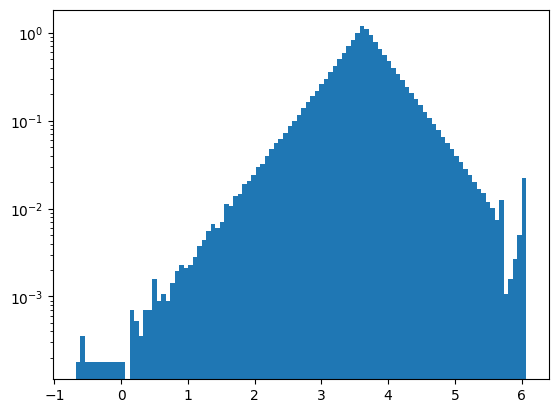

In [23]:
plt.hist(np.log10(f_k_grid.flatten()), bins=100, density=True)
plt.yscale('log')
#plt.xscale('log')

In [24]:
omega_m_grid

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.98997494, -0.98997494, -0.98997494, ..., -0.98997494,
        -0.98997494, -0.98997494],
       [-0.97994987, -0.97994987, -0.97994987, ..., -0.97994987,
        -0.97994987, -0.97994987],
       ...,
       [ 2.97994987,  2.97994987,  2.97994987, ...,  2.97994987,
         2.97994987,  2.97994987],
       [ 2.98997494,  2.98997494,  2.98997494, ...,  2.98997494,
         2.98997494,  2.98997494],
       [ 3.        ,  3.        ,  3.        , ...,  3.        ,
         3.        ,  3.        ]], shape=(400, 400))

### Plot

/tmp/ipykernel_11297/2462306219.py:1: RuntimeWarning: invalid value encountered in log10
  plot = plt.contourf(omega_m, omega_lambda, np.log10(f_k_grid), levels=np.linspace(0, 6.1, 100), cmap="jet", extend='both')


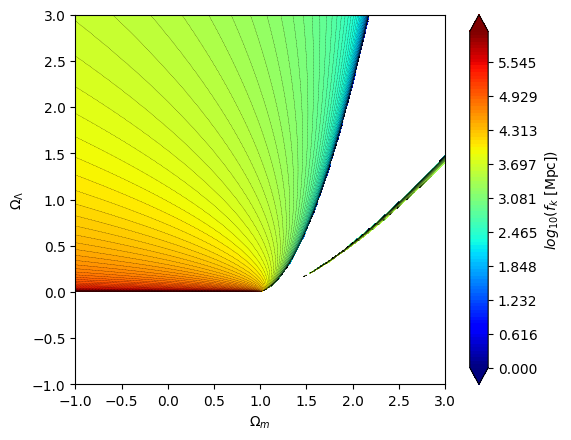

In [28]:


plot = plt.contourf(omega_m, omega_lambda, np.log10(f_k_grid), levels=np.linspace(0, 6.1, 100), cmap="jet", extend='both')
plt.axis('scaled')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.colorbar(plot, label=r'$log_{10}(f_k$ [Mpc])')
plt.contour(plot, colors='k', linestyles='--', linewidths=0.2)
plt.show()

# Tests

In [ ]:
def f_k(omega_k, omega_m, omega_lambda, E_grid):
    if omega_k > 0:
        return (c / H_0) * np.sinh(np.sqrt(omega_k) * E_grid)/ np.sqrt(omega_k)
    elif omega_k < 0:
        return (c / H_0) * np.sin(np.sqrt(-omega_k) * E_grid)/ np.sqrt(-omega_k)
    else:
        return (c / H_0) * E_grid

f_k = np.vectorize(f_k)
f_k_grid = f_k(omega_k_grid, omega_m_grid, omega_lambda_grid, E_grid)
